# Fine-tune a CamemBERT model for span classification on the GeoEDdA dataset


This notebook shows how to fine-tune a CamemBERT model for span classification on French texts.

The model is available on HuggingFace: 
https://huggingface.co/GEODE/xxx

We use the GeoEDdA dataset available also on HuggingFace:
https://huggingface.co/datasets/GEODE/GeoEDdA

For more details about the dataset and tagset used, see: https://github.com/GEODE-project/ner-spancat-edda

In [1]:
import torch
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from sklearn.metrics import multilabel_confusion_matrix
from sklearn_crfsuite.utils import flatten
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
import os
import json
import matplotlib.pyplot as plt
from utils import filter_tags, format, get_data

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
device

device(type='mps')

In [3]:
dataset = load_dataset("GEODE/GeoEDdA")

In [4]:
dfs = []
for key in dataset.keys():
    dfs.append(pd.DataFrame({'dataset':key, 'text':dataset[key]['text'], 'meta':dataset[key]['meta'], 'tokens':dataset[key]['tokens'], 'spans':dataset[key]['spans']}))
df = pd.concat(dfs, ignore_index=True)

In [5]:
df.head()

,dataset,text,meta,tokens,spans
0,train,"ILLESCAS, (Géog.) petite ville d'Espagne, dans...","{'volume': 8, 'head': 'ILLESCAS', 'author': 'u...","[{'text': 'ILLESCAS', 'start': 0, 'end': 8, 'i...","[{'text': 'ILLESCAS', 'start': 0, 'end': 8, 't..."
1,train,"MULHAUSEN, (Géog.) ville impériale d'Allemagne...","{'volume': 10, 'head': 'MULHAUSEN', 'author': ...","[{'text': 'MULHAUSEN', 'start': 0, 'end': 9, '...","[{'text': 'MULHAUSEN', 'start': 0, 'end': 9, '..."
2,train,"* ADDA, riviere de Suisse & d'Italie, qui a sa...","{'volume': 1, 'head': 'ADDA', 'author': 'Dider...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ADDA', 'start': 2, 'end': 6, 'token..."
3,train,"SINTRA ou CINTRA, (Géog. mod.) montagne de Por...","{'volume': 15, 'head': 'SINTRA ou CINTRA', 'au...","[{'text': 'SINTRA', 'start': 0, 'end': 6, 'id'...","[{'text': 'SINTRA ou CINTRA', 'start': 0, 'end..."
4,train,"* ACHSTEDE, ou AKSTEDE, s. petite Ville d'Alle...","{'volume': 1, 'head': 'ACHSTEDE, ou AKSTEDE', ...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ACHSTEDE, ou AKSTEDE', 'start': 2, ..."


In [7]:
tagset_filter = ['Head', 'Domain-mark', 'NC-Spatial', 'NC-Person', 'NP-Spatial', 'NP-Person', 'NP-Misc', 'Relation', 'Latlong']

df['tags'] = df.apply(lambda x:[' '.join(label) for label in filter_tags(x, tagset_filter, remove_nested=True)], axis=1)

tagset = set([tag for tags in df['tags'] for tag in tags])

label2id, id2label = {tag: i for i, tag in enumerate(tagset)}, {i: tag for i, tag in enumerate(tagset)}

In [9]:
df['ids'] = df.apply(lambda x: format(list(x['tags']), label2id), axis=1)

In [10]:
df.head()

,dataset,text,meta,tokens,spans,tags,ids
0,train,"ILLESCAS, (Géog.) petite ville d'Espagne, dans...","{'volume': 8, 'head': 'ILLESCAS', 'author': 'u...","[{'text': 'ILLESCAS', 'start': 0, 'end': 8, 'i...","[{'text': 'ILLESCAS', 'start': 0, 'end': 8, 't...","[Head, O, O, Domain-mark, Domain-mark, O, NC-S...","[3, 1, 1, 9, 9, 1, 5, 5, 1, 0, 1, 7, 0, 0, 0, ..."
1,train,"MULHAUSEN, (Géog.) ville impériale d'Allemagne...","{'volume': 10, 'head': 'MULHAUSEN', 'author': ...","[{'text': 'MULHAUSEN', 'start': 0, 'end': 9, '...","[{'text': 'MULHAUSEN', 'start': 0, 'end': 9, '...","[Head, O, O, Domain-mark, Domain-mark, O, NC-S...","[3, 1, 1, 9, 9, 1, 5, 5, 1, 0, 1, 7, 0, 0, 1, ..."
2,train,"* ADDA, riviere de Suisse & d'Italie, qui a sa...","{'volume': 1, 'head': 'ADDA', 'author': 'Dider...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ADDA', 'start': 2, 'end': 6, 'token...","[O, Head, O, NC-Spatial, O, NP-Spatial, O, O, ...","[1, 3, 1, 5, 1, 0, 1, 1, 0, 1, 1, 7, 7, 7, 7, ..."
3,train,"SINTRA ou CINTRA, (Géog. mod.) montagne de Por...","{'volume': 15, 'head': 'SINTRA ou CINTRA', 'au...","[{'text': 'SINTRA', 'start': 0, 'end': 6, 'id'...","[{'text': 'SINTRA ou CINTRA', 'start': 0, 'end...","[Head, Head, Head, O, O, Domain-mark, Domain-m...","[3, 3, 3, 1, 1, 9, 9, 9, 9, 1, 5, 1, 0, 7, 0, ..."
4,train,"* ACHSTEDE, ou AKSTEDE, s. petite Ville d'Alle...","{'volume': 1, 'head': 'ACHSTEDE, ou AKSTEDE', ...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ACHSTEDE, ou AKSTEDE', 'start': 2, ...","[O, Head, Head, Head, Head, O, O, NC-Spatial, ...","[1, 3, 3, 3, 3, 1, 1, 5, 5, 1, 0, 7, 5, 5, 1, ..."


In [12]:
data = get_data((df.to_dict('records')))

train_dataset = Dataset.from_list(data['train'])
val_dataset = Dataset.from_list(data['validation'])

In [13]:
model_base = "camembert-base"

tokenizer = AutoTokenizer.from_pretrained(model_base, clean_up_tokenization_spaces=True)


In [14]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True, padding="max_length")
    labels = []
    word_idss = []
    for i, label in enumerate(examples[f"tags_id"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        label_ids = []
        for j, word_idx in enumerate(word_ids):  
            if word_idx is None:
                label_ids.append(label2id['O'])
            else:
                label_ids.append(label[word_idx])
        labels.append(label_ids)
        word_idss.append(word_ids)
    tokenized_inputs["labels"] = labels
    tokenized_inputs['word_ids'] = word_idss
    return tokenized_inputs


In [15]:
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

### Example

In [16]:
sample = tokenized_train_dataset[0]
print("Token\t\t Label")
for token_id, token_labels in zip(sample["input_ids"], sample["labels"]):
    token_text = tokenizer.decode(token_id)
    labels = id2label[token_labels]
    print(f" {token_text} \t\t {labels}")
    if token_text == "</s>":
        break

Token		 Label
 <s> 		 O
  		 Head
 ILLE 		 Head
 SC 		 Head
 AS 		 Head
  		 O
 , 		 O
 ( 		 O
 Géo 		 Domain-mark
 g 		 Domain-mark
  		 Domain-mark
 . 		 Domain-mark
 ) 		 O
 petite 		 NC-Spatial
 ville 		 NC-Spatial
 d 		 O
 ' 		 O
 Espagne 		 NP-Spatial
  		 O
 , 		 O
 dans 		 Relation
 la 		 NP-Spatial
 nouvelle 		 NP-Spatial
 Cast 		 NP-Spatial
 ille 		 NP-Spatial
  		 Relation
 , 		 Relation
 à 		 Relation
 six 		 Relation
 lieu 		 Relation
 es 		 Relation
 au 		 Relation
 sud 		 Relation
 de 		 Relation
 Madrid 		 NP-Spatial
  		 O
 . 		 O
 </s> 		 O


In [21]:
def divide(a: int, b: int):
    return a / b if b > 0 else 0


def compute_metrics(p):
    predictions, true_labels = p
    metrics = {}
    cm = multilabel_confusion_matrix(flatten(true_labels), [np.argmax(token) for sentence in predictions for token in sentence], labels=list(id2label.keys()))
    for label_idx, matrix in enumerate(cm):
        if id2label[label_idx] == 'O':
            continue
        tp, fp, fn = matrix[1, 1], matrix[0, 1], matrix[1, 0]
        precision = divide(tp, tp + fp)
        recall = divide(tp, tp + fn)
        f1 = divide(2 * precision * recall, precision + recall)
        metrics[f"f1_{id2label[label_idx]}"] = f1
    macro_f1 = sum(list(metrics.values())) / (len(list(id2label.keys())) - 1)
    metrics["macro_f1"] = macro_f1
    return metrics

In [18]:
model = AutoModelForTokenClassification.from_pretrained(model_base, num_labels = len(tagset), id2label=id2label, label2id=label2id).to(device)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
output_model_name = 'camembert-base-edda-span-classification'

training_args = TrainingArguments(
    output_dir = os.path.join('models', output_model_name),
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    num_train_epochs = 10,
    learning_rate = 1e-4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    metric_for_best_model = 'macro_f1',
    load_best_model_at_end = True,
    save_total_limit = 1,
    logging_steps = 225,
    seed = 42
    )

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_val_dataset,
    compute_metrics = compute_metrics
)

In [23]:
trainer.train()

  0%|          | 0/2250 [00:00<?, ?it/s]

{'loss': 0.0815, 'grad_norm': 0.2591468095779419, 'learning_rate': 9e-05, 'epoch': 1.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03710191324353218, 'eval_f1_NP-Spatial': 0.9216417910447762, 'eval_f1_NP-Misc': 0.7361647361647362, 'eval_f1_Head': 0.9392831016825165, 'eval_f1_Latlong': 0.9840860215053764, 'eval_f1_NC-Spatial': 0.8848101265822784, 'eval_f1_NC-Person': 0.7577413479052822, 'eval_f1_Relation': 0.8940609951845907, 'eval_f1_NP-Person': 0.8357843137254902, 'eval_f1_Domain-mark': 0.9812453113278321, 'eval_macro_f1': 0.8816464161247644, 'eval_runtime': 5.1332, 'eval_samples_per_second': 38.962, 'eval_steps_per_second': 4.87, 'epoch': 1.0}
{'loss': 0.0606, 'grad_norm': 0.3313067555427551, 'learning_rate': 8e-05, 'epoch': 2.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.030643250793218613, 'eval_f1_NP-Spatial': 0.9299009900990098, 'eval_f1_NP-Misc': 0.7435158501440922, 'eval_f1_Head': 0.971990915972748, 'eval_f1_Latlong': 0.9792387543252595, 'eval_f1_NC-Spatial': 0.8715534633490248, 'eval_f1_NC-Person': 0.7394366197183099, 'eval_f1_Relation': 0.9185059422750425, 'eval_f1_NP-Person': 0.8679678530424799, 'eval_f1_Domain-mark': 0.9933283914010378, 'eval_macro_f1': 0.8906043089252227, 'eval_runtime': 5.343, 'eval_samples_per_second': 37.432, 'eval_steps_per_second': 4.679, 'epoch': 2.0}
{'loss': 0.0503, 'grad_norm': 0.43031057715415955, 'learning_rate': 7e-05, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.02852417156100273, 'eval_f1_NP-Spatial': 0.9406645569620253, 'eval_f1_NP-Misc': 0.7698412698412698, 'eval_f1_Head': 0.9556213017751479, 'eval_f1_Latlong': 0.977291841883936, 'eval_f1_NC-Spatial': 0.8839634941329857, 'eval_f1_NC-Person': 0.7293729372937294, 'eval_f1_Relation': 0.9130434782608696, 'eval_f1_NP-Person': 0.8717339667458434, 'eval_f1_Domain-mark': 0.9933283914010378, 'eval_macro_f1': 0.8927623598107606, 'eval_runtime': 6.0414, 'eval_samples_per_second': 33.105, 'eval_steps_per_second': 4.138, 'epoch': 3.0}
{'loss': 0.0469, 'grad_norm': 0.2944350242614746, 'learning_rate': 6e-05, 'epoch': 4.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.031233999878168106, 'eval_f1_NP-Spatial': 0.9427880741337632, 'eval_f1_NP-Misc': 0.6947960618846695, 'eval_f1_Head': 0.9660889223813113, 'eval_f1_Latlong': 0.9836769759450172, 'eval_f1_NC-Spatial': 0.8896232650363516, 'eval_f1_NC-Person': 0.7351916376306621, 'eval_f1_Relation': 0.9069958847736626, 'eval_f1_NP-Person': 0.8883610451306413, 'eval_f1_Domain-mark': 0.9933283914010378, 'eval_macro_f1': 0.8889833620352352, 'eval_runtime': 4.984, 'eval_samples_per_second': 40.129, 'eval_steps_per_second': 5.016, 'epoch': 4.0}
{'loss': 0.0107, 'grad_norm': 0.29299139976501465, 'learning_rate': 5e-05, 'epoch': 5.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03134739771485329, 'eval_f1_NP-Spatial': 0.9499806126405583, 'eval_f1_NP-Misc': 0.7168262653898768, 'eval_f1_Head': 0.9699306090979183, 'eval_f1_Latlong': 0.9836488812392428, 'eval_f1_NC-Spatial': 0.8883312421580929, 'eval_f1_NC-Person': 0.726984126984127, 'eval_f1_Relation': 0.9154811715481171, 'eval_f1_NP-Person': 0.8785046728971964, 'eval_f1_Domain-mark': 0.9933283914010378, 'eval_macro_f1': 0.8914462192617962, 'eval_runtime': 4.9988, 'eval_samples_per_second': 40.01, 'eval_steps_per_second': 5.001, 'epoch': 5.0}
{'loss': 0.008, 'grad_norm': 0.1355111449956894, 'learning_rate': 4e-05, 'epoch': 6.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03293617069721222, 'eval_f1_NP-Spatial': 0.9469964664310954, 'eval_f1_NP-Misc': 0.7282758620689654, 'eval_f1_Head': 0.9671361502347418, 'eval_f1_Latlong': 0.9832258064516128, 'eval_f1_NC-Spatial': 0.8957528957528956, 'eval_f1_NC-Person': 0.7208480565371024, 'eval_f1_Relation': 0.9206081081081081, 'eval_f1_NP-Person': 0.887115165336374, 'eval_f1_Domain-mark': 0.99182156133829, 'eval_macro_f1': 0.8935311191399093, 'eval_runtime': 4.9123, 'eval_samples_per_second': 40.714, 'eval_steps_per_second': 5.089, 'epoch': 6.0}
{'loss': 0.0062, 'grad_norm': 0.22513772547245026, 'learning_rate': 3e-05, 'epoch': 7.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.035727716982364655, 'eval_f1_NP-Spatial': 0.9418742586002372, 'eval_f1_NP-Misc': 0.7217280813214739, 'eval_f1_Head': 0.975987606506584, 'eval_f1_Latlong': 0.984099699183498, 'eval_f1_NC-Spatial': 0.870825456836799, 'eval_f1_NC-Person': 0.6932849364791288, 'eval_f1_Relation': 0.9139966273187183, 'eval_f1_NP-Person': 0.8949232585596221, 'eval_f1_Domain-mark': 0.9933283914010378, 'eval_macro_f1': 0.8877831462452332, 'eval_runtime': 5.076, 'eval_samples_per_second': 39.401, 'eval_steps_per_second': 4.925, 'epoch': 7.0}
{'loss': 0.0048, 'grad_norm': 0.0901811495423317, 'learning_rate': 2e-05, 'epoch': 8.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03583226725459099, 'eval_f1_NP-Spatial': 0.9509611612397018, 'eval_f1_NP-Misc': 0.7379400260756194, 'eval_f1_Head': 0.9721595184349134, 'eval_f1_Latlong': 0.984099699183498, 'eval_f1_NC-Spatial': 0.882837238758708, 'eval_f1_NC-Person': 0.7364620938628159, 'eval_f1_Relation': 0.911690496215307, 'eval_f1_NP-Person': 0.8899082568807339, 'eval_f1_Domain-mark': 0.9940652818991098, 'eval_macro_f1': 0.8955693080611563, 'eval_runtime': 5.1616, 'eval_samples_per_second': 38.748, 'eval_steps_per_second': 4.843, 'epoch': 8.0}
{'loss': 0.0044, 'grad_norm': 0.09283790737390518, 'learning_rate': 1e-05, 'epoch': 9.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03707649186253548, 'eval_f1_NP-Spatial': 0.9495896834701055, 'eval_f1_NP-Misc': 0.7262872628726288, 'eval_f1_Head': 0.9823754789272031, 'eval_f1_Latlong': 0.9823504089539388, 'eval_f1_NC-Spatial': 0.8909090909090909, 'eval_f1_NC-Person': 0.7204301075268817, 'eval_f1_Relation': 0.9089390142021722, 'eval_f1_NP-Person': 0.899188876013905, 'eval_f1_Domain-mark': 0.9933283914010378, 'eval_macro_f1': 0.8948220349196626, 'eval_runtime': 5.3325, 'eval_samples_per_second': 37.506, 'eval_steps_per_second': 4.688, 'epoch': 9.0}
{'loss': 0.0037, 'grad_norm': 0.11044501513242722, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.03770970180630684, 'eval_f1_NP-Spatial': 0.9478635829086633, 'eval_f1_NP-Misc': 0.7221476510067113, 'eval_f1_Head': 0.9779131759329779, 'eval_f1_Latlong': 0.9836629406706793, 'eval_f1_NC-Spatial': 0.8841038632045598, 'eval_f1_NC-Person': 0.7288732394366197, 'eval_f1_Relation': 0.9089390142021722, 'eval_f1_NP-Person': 0.9, 'eval_f1_Domain-mark': 0.9933283914010378, 'eval_macro_f1': 0.8940924287514913, 'eval_runtime': 4.368, 'eval_samples_per_second': 45.788, 'eval_steps_per_second': 5.723, 'epoch': 10.0}
{'train_runtime': 1724.7644, 'train_samples_per_second': 10.436, 'train_steps_per_second': 1.305, 'train_loss': 0.02772195365693834, 'epoch': 10.0}


TrainOutput(global_step=2250, training_loss=0.02772195365693834, metrics={'train_runtime': 1724.7644, 'train_samples_per_second': 10.436, 'train_steps_per_second': 1.305, 'total_flos': 4703681802240000.0, 'train_loss': 0.02772195365693834, 'epoch': 10.0})

In [24]:
best_model_checkpoint = trainer.state.best_model_checkpoint
best_model_checkpoint

'models/camembert-base-edda-span-classification/checkpoint-1800'

In [25]:
train_logs = trainer.state.log_history

with open(os.path.join('training_logs',output_model_name+'.json'), "w") as json_file:
    json.dump(train_logs, json_file)

In [26]:
trainer.save_model(output_model_name)

In [27]:
with open(os.path.join('training_logs',output_model_name+'.json')) as json_file:
    train_logs = json.load(json_file)

In [28]:
eval_loss = []
loss = []
metrics = {}
for label in ["eval_f1_"+i for i in [j for j in tagset if j != 'O']]:
    metrics[label] = []

for log in train_logs:
    if("loss" in log.keys()):
        loss.append(log['loss'])
    if("eval_loss" in log.keys()):
        eval_loss.append(log['eval_loss'])
    common = list(set(list(metrics.keys())).intersection(list(log.keys())))
    for element in common:
        metrics[element].append(log[element])

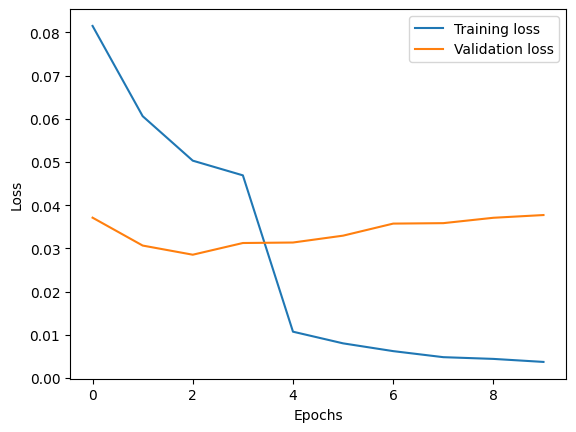

In [29]:
plt.plot(loss, label="Training loss")
plt.plot(eval_loss, label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

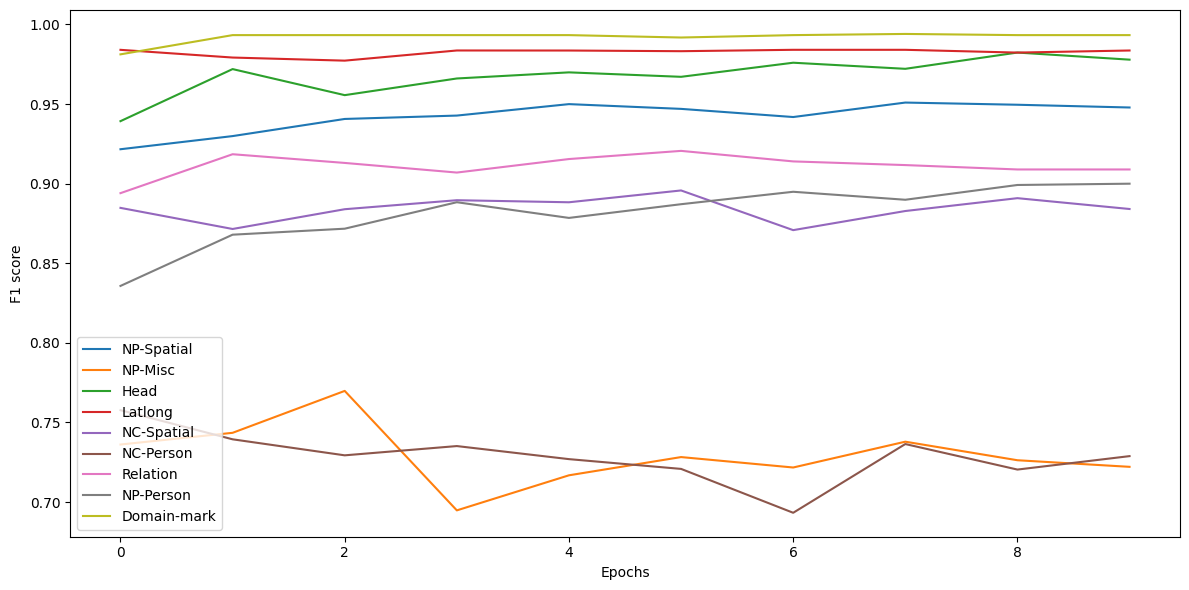

In [30]:
plt.figure(figsize=(12,6))
for key,value in metrics.items():
    plt.plot(value, label=key[8:])
plt.xlabel('Epochs')
plt.ylabel('F1 score')
plt.legend()
plt.tight_layout()
plt.show()